# Neural Network tuning

## Libraries

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.callbacks import ModelCheckpoint

import seaborn as sns

#from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
#from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
#from sklearn.metrics import precision_recall_curve, average_precision_score


In [9]:
from modules.data_exploration.data_ex import import_data, gen_bulk_data, get_bulk_inst
from modules.build_ml_models.NN_classification import build_model, plot_confusion_matrix, print_classification_report 
from modules.build_ml_models.NN_classification import plot_learning_curves, plot_learning_loss, plot_learning_curves_opt


## Load data

In [10]:
file_path = 'data/churn.csv'
data_dict = gen_bulk_data(file_path)
data_dict.keys()

dict_keys(['original', 'dropped', 'scaled', 'encoded', 'encoded and scaled', 'scaled and dropped'])

In [11]:
key = 'scaled and dropped'

x_train, x_test, x_val, y_train, y_test, y_val = get_bulk_inst(data_dict, key)

In [12]:
x_train

,international_plan,voice_mail_plan,account_length,number_customer_service_calls,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls
0,0,0,-0.533083,-0.435125,-0.580246,-0.622228,-1.414808,-0.703917,0.081792,0.841570,0.351184,-0.654116,1.876075
1,0,0,-1.213339,0.324445,-0.580246,-1.032210,1.555544,1.985098,0.894923,-0.148755,0.301490,0.489372,-0.171148
2,0,0,0.525093,0.324445,-0.580246,-0.861539,0.598990,-0.117441,0.183434,-0.791393,1.941409,0.096298,-0.990037
3,0,1,-0.003995,-0.435125,1.252992,1.225476,-0.307219,-1.188658,0.589999,-0.201495,0.450573,0.989649,0.238297
4,0,1,1.961189,3.362724,1.766298,-0.590691,-0.256874,-0.047622,-2.306780,-0.256187,0.649351,0.060564,1.057186
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0,0,-0.986587,0.324445,-0.580246,-1.714896,-2.018947,-1.422052,0.386716,-0.607782,-0.642706,1.096851,-0.171148
3496,0,0,-0.533083,-0.435125,-0.580246,-1.842899,-0.458254,0.293492,1.301489,0.894310,-0.742096,0.239234,-0.171148
3497,0,0,-1.238534,-1.194695,-0.580246,-0.071256,1.454854,0.357326,1.250668,-0.316740,-2.431710,-0.403978,-0.171148
3498,0,1,0.953402,-1.194695,0.959674,-2.987511,2.461753,-1.198633,0.437537,-0.398778,0.549962,-0.832786,-1.399482


In [13]:
print(y_test)
print(y_test.shape)

0      0
1      0
2      0
3      0
4      0
      ..
745    1
746    0
747    0
748    0
749    0
Name: class, Length: 750, dtype: int64
(750,)


In [14]:
inp_shape = x_train.shape[1]

# Build model

## Run model and save weights for each epoch

In [30]:
epo = 1000

optimizer= Adam(0.005)

model_simple = build_model(input_shape=inp_shape, hidden_shapes=[32], hidden_activation='relu',
                    opt=optimizer, dropout=0.0, loss='binary_crossentropy')

filepath = "modules/build_ml_models/saved_models/weight_{epoch:03d}.hdf5"
CB_checkpoint = ModelCheckpoint(filepath=filepath,
                                save_weights_only=True, 
                                save_best_only=False, 
                                save_freq=1, 
                                verbose=0)


history = model_simple.fit(x_train, y_train, epochs=epo, validation_data=(x_val, y_val), callbacks=[CB_checkpoint], verbose=0)

## Get best models for specific metrics

## Plot learning curves


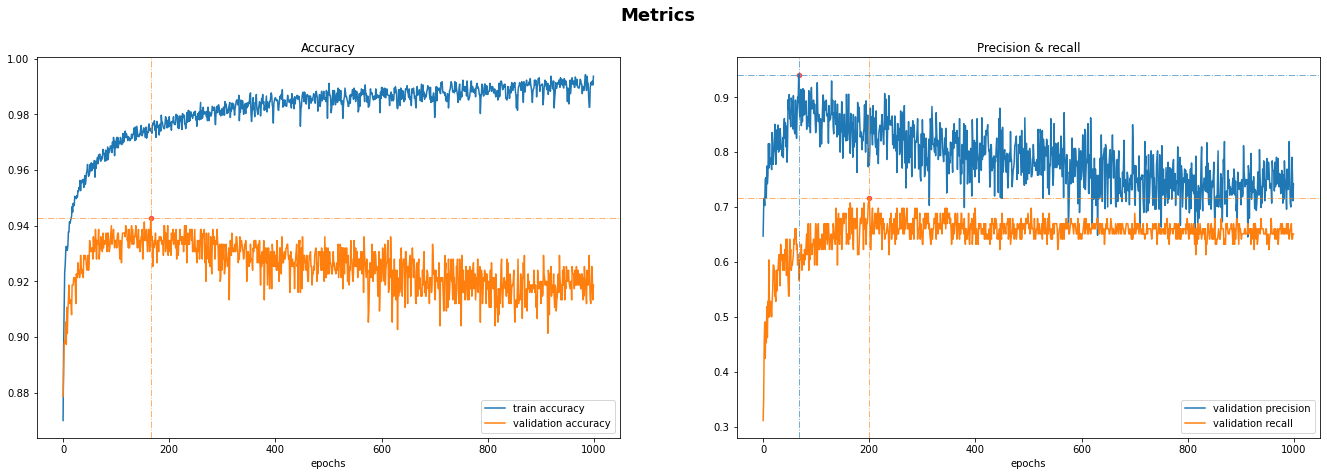

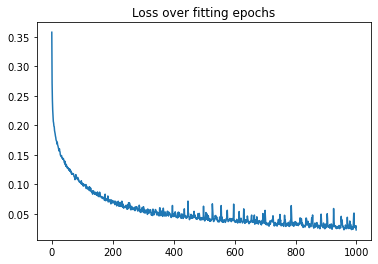

Min loss: 0.022873850539326668


In [33]:
plot_learning_curves_opt(history)
plot_learning_loss(history)

# Methods to iterate several architectures

In [34]:
import numpy as np

def get_best_metric_epoch(history):
    best_epoch_loss = np.argmin(history.history['loss'])
    best_epoch_val_accuracy = np.argmax(history.history['val_accuracy'])
    best_epoch_val_precision = np.argmax(history.history['val_precision'])
    best_epoch_val_recall = np.argmax(history.history['val_recall'])
    
    return best_epoch_loss, best_epoch_val_accuracy, best_epoch_val_precision, best_epoch_val_recall
    

In [35]:
ep_loss, ep_val_accuracy, ep_val_precision, ep_val_recall = get_best_metric_epoch(history)
get_best_metric_epoch(history)

(999, 165, 67, 200)

In [45]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

def test_shapes(test_comb=[ [16],[64],[128],[256] ], epochs=10):
    
    optimizer= Adam(0.005)
    threshold = 0.5
    df_result = pd.DataFrame(columns=['Model-hidden layers', 'Best Parameter', 'Accuracy', '0 Precision', '0 Recall', '1 Precision', '1 Recall'])


    # iterate all given shapes
    for hidden_shape in test_comb:
        print("\n\n=== Hidden layer size:", hidden_shape, "===\n")

        filepath = "modules/build_ml_models/saved_models/weight_{epoch:03d}.hdf5"
        CB_checkpoint = ModelCheckpoint(filepath=filepath,
                                        save_weights_only=True, 
                                        save_best_only=False, 
                                        save_freq=1, 
                                        verbose=0)

        model = build_model(input_shape=inp_shape, hidden_shapes=hidden_shape, hidden_activation='relu',
                            opt=optimizer, dropout=0.0, loss='binary_crossentropy')

        #model.summary()
        
        history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), callbacks=[CB_checkpoint], verbose=0)
             


        for param, param_name in zip(get_best_metric_epoch(history), ['Loss', 'Accuracy', 'Precision', 'Recall']) :

            model_path = f"modules/build_ml_models/saved_models/weight_{param+1:03d}.hdf5"    
            print (model_path)
            model.load_weights(model_path)
            y_pred = model.predict(x_test)
            y_pred = np.where(y_pred<=threshold, 0, 1)
            cr = classification_report(y_test, y_pred, output_dict=True)
            #print(cr,'\n')     
            #print('Parameter:', param_name)
            #print('Accuracy:',cr['accuracy'])
            #print('0 Precision:',cr['0']['precision'])
            #print('0 Recall:',cr['0']['recall'])
            #print('1 Precision:',cr['1']['precision'])
            #print('1 Recall:',cr['1']['recall'])


            # extend dtaframe
            to_append = [ hidden_shape, param_name, cr['accuracy'], cr['0']['precision'], cr['0']['recall'], cr['1']['precision'], cr['1']['recall'] ]
            df_length = len(df_result)
            df_result.loc[df_length] = to_append


        #display(df_result)
    return df_result

# Single layer

In [46]:
df = test_shapes(test_comb=[ [16],[32],[64],[128],[256] ], epochs=800)



=== Hidden layer size: [16] ===

modules/build_ml_models/saved_models/weight_783.hdf5
modules/build_ml_models/saved_models/weight_121.hdf5
modules/build_ml_models/saved_models/weight_134.hdf5
modules/build_ml_models/saved_models/weight_696.hdf5


=== Hidden layer size: [32] ===

modules/build_ml_models/saved_models/weight_792.hdf5
modules/build_ml_models/saved_models/weight_144.hdf5
modules/build_ml_models/saved_models/weight_067.hdf5
modules/build_ml_models/saved_models/weight_592.hdf5


=== Hidden layer size: [64] ===

modules/build_ml_models/saved_models/weight_766.hdf5
modules/build_ml_models/saved_models/weight_016.hdf5
modules/build_ml_models/saved_models/weight_014.hdf5
modules/build_ml_models/saved_models/weight_017.hdf5


=== Hidden layer size: [128] ===

modules/build_ml_models/saved_models/weight_796.hdf5
modules/build_ml_models/saved_models/weight_016.hdf5
modules/build_ml_models/saved_models/weight_010.hdf5
modules/build_ml_models/saved_models/weight_444.hdf5


=== Hidde

In [47]:
display(df)

,Model-hidden layers,Best Parameter,Accuracy,0 Precision,0 Recall,1 Precision,1 Recall
0,[16],Loss,0.952000,0.963415,0.981366,0.872340,0.773585
1,[16],Accuracy,0.954667,0.966361,0.981366,0.875000,0.792453
2,[16],Precision,0.949333,0.959091,0.982919,0.877778,0.745283
3,[16],Recall,0.948000,0.971919,0.967391,0.807339,0.830189
4,[32],Loss,0.928000,0.962382,0.953416,0.732143,0.773585
5,[32],Accuracy,0.953333,0.963470,0.982919,0.881720,0.773585
6,[32],Precision,0.948000,0.956259,0.984472,0.885057,0.726415
7,[32],Recall,0.918667,0.967897,0.936335,0.677165,0.811321
8,[64],Loss,0.925333,0.959375,0.953416,0.727273,0.754717
9,[64],Accuracy,0.949333,0.963303,0.978261,0.854167,0.773585


## Multilayer 

In [51]:
# Number of hidden layers

from itertools import combinations_with_replacement, product
from random import sample

# initial set of layer size
x = [32, 64, 128]

# create combinations
c_2 = product(x, repeat=2) # 2 hidden layers
c_3 = product(x, repeat=3) # 3 hidden layers
c_4 = product(x, repeat=4) # 4 hidden layers
c_5 = product(x, repeat=5) # 5 hidden layers


# take 40 random combinations
c_2_sample = sample(list(c_2), 3)
c_3_sample = sample(list(c_3), 3)
c_4_sample = sample(list(c_4), 3)
#c_5_sample = sample(list(c_5), 3)

test_comb = c_2_sample + c_3_sample + c_4_sample# + c_5_sample

print(f" {len(test_comb)} test combinations chosen:\n{test_comb}")

 9 test combinations chosen:
[(128, 32), (128, 128), (64, 32), (64, 64, 64), (128, 32, 64), (128, 32, 128), (32, 128, 32, 64), (64, 64, 32, 32), (64, 32, 64, 32)]


In [52]:
df_multi = test_shapes(test_comb=test_comb, epochs=800)



=== Hidden layer size: (128, 32) ===

modules/build_ml_models/saved_models/weight_800.hdf5
modules/build_ml_models/saved_models/weight_048.hdf5
modules/build_ml_models/saved_models/weight_007.hdf5
modules/build_ml_models/saved_models/weight_020.hdf5


=== Hidden layer size: (128, 128) ===

modules/build_ml_models/saved_models/weight_730.hdf5
modules/build_ml_models/saved_models/weight_015.hdf5
modules/build_ml_models/saved_models/weight_012.hdf5
modules/build_ml_models/saved_models/weight_024.hdf5


=== Hidden layer size: (64, 32) ===

modules/build_ml_models/saved_models/weight_759.hdf5
modules/build_ml_models/saved_models/weight_025.hdf5
modules/build_ml_models/saved_models/weight_007.hdf5
modules/build_ml_models/saved_models/weight_046.hdf5


=== Hidden layer size: (64, 64, 64) ===

modules/build_ml_models/saved_models/weight_372.hdf5
modules/build_ml_models/saved_models/weight_022.hdf5
modules/build_ml_models/saved_models/weight_012.hdf5
modules/build_ml_models/saved_models/weigh

In [53]:
df_multi

,Model-hidden layers,Best Parameter,Accuracy,0 Precision,0 Recall,1 Precision,1 Recall
0,"(128, 32)",Loss,0.936000,0.957055,0.968944,0.795918,0.735849
1,"(128, 32)",Accuracy,0.940000,0.967239,0.962733,0.779817,0.801887
2,"(128, 32)",Precision,0.938667,0.937135,0.995342,0.954545,0.594340
3,"(128, 32)",Recall,0.945333,0.970359,0.965839,0.798165,0.820755
4,"(128, 128)",Loss,0.942667,0.955994,0.978261,0.846154,0.726415
5,"(128, 128)",Accuracy,0.953333,0.966309,0.979814,0.865979,0.792453
6,"(128, 128)",Precision,0.940000,0.945022,0.987578,0.896104,0.650943
7,"(128, 128)",Recall,0.937333,0.971564,0.954969,0.752137,0.830189
8,"(64, 32)",Loss,0.920000,0.952012,0.954969,0.721154,0.707547
9,"(64, 32)",Accuracy,0.945333,0.956127,0.981366,0.865169,0.726415


# Our nice model

In [70]:
epo = 1000

optimizer= Adam(0.005)

model_nice = build_model(input_shape=inp_shape, hidden_shapes=[128, 32, 128], hidden_activation='relu',
                    opt=optimizer, dropout=0.0, loss='binary_crossentropy')

filepath = "modules/build_ml_models/saved_models/weight_{epoch:03d}.hdf5"
CB_checkpoint = ModelCheckpoint(filepath=filepath,
                                save_weights_only=True, 
                                save_best_only=False, 
                                save_freq=1, 
                                verbose=0)


history_nice = model_nice.fit(x_train, y_train, epochs=epo, validation_data=(x_val, y_val), callbacks=[CB_checkpoint], verbose=0)

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 13)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               1792      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 32)                4128      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 10,273
Trainable params: 10,273
Non-trainable params: 0
_________________________________________________________________


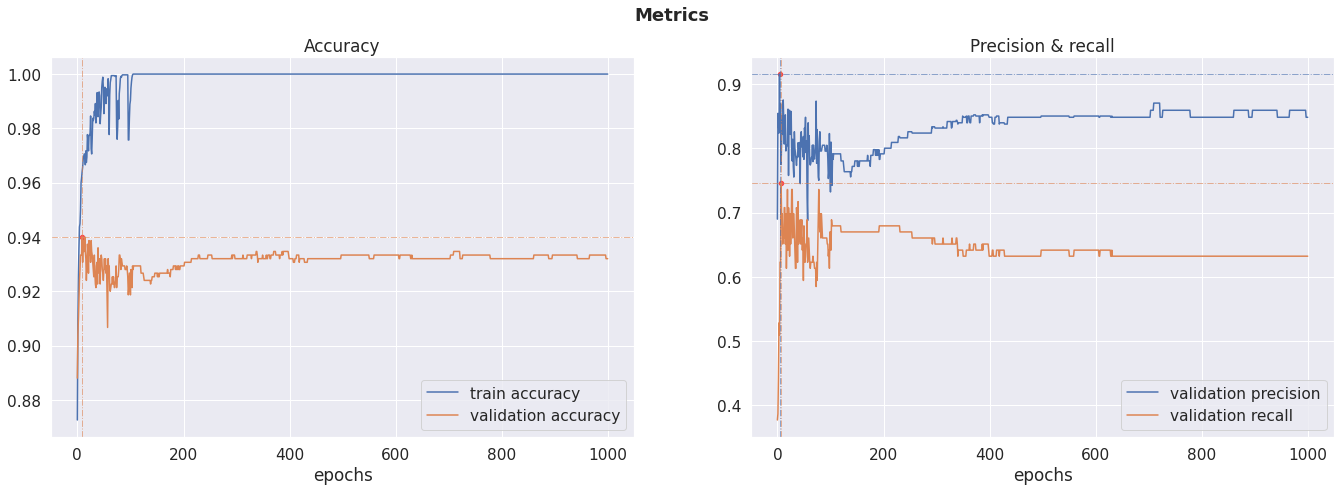

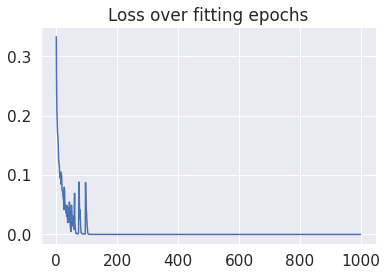

Min loss: 2.3574409091509096e-10


In [71]:
model_nice.summary()
plot_learning_curves_opt(history_nice)
plot_learning_loss(history_nice)

In [72]:
ep_loss, ep_val_accuracy, ep_val_precision, ep_val_recall = get_best_metric_epoch(history_nice)
get_best_metric_epoch(history_nice)

(609, 9, 4, 7)

===== Loss =====

modules/build_ml_models/saved_models/weight_610.hdf5


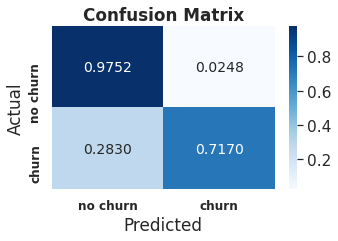

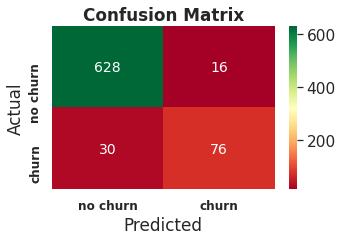


Classification report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       644
           1       0.83      0.72      0.77       106

    accuracy                           0.94       750
   macro avg       0.89      0.85      0.87       750
weighted avg       0.94      0.94      0.94       750

===== Accuracy =====

modules/build_ml_models/saved_models/weight_010.hdf5


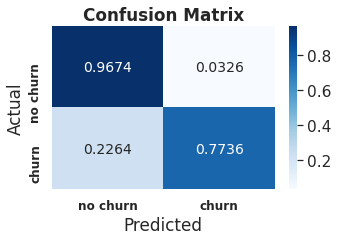

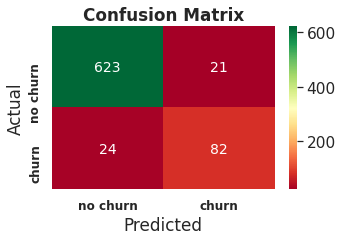


Classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       644
           1       0.80      0.77      0.78       106

    accuracy                           0.94       750
   macro avg       0.88      0.87      0.87       750
weighted avg       0.94      0.94      0.94       750

===== Precision =====

modules/build_ml_models/saved_models/weight_005.hdf5


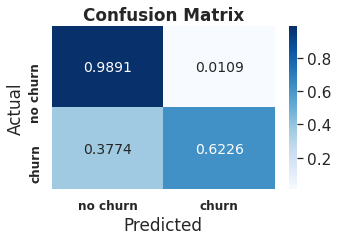

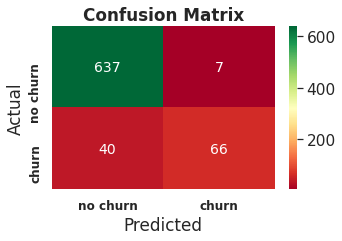


Classification report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       644
           1       0.90      0.62      0.74       106

    accuracy                           0.94       750
   macro avg       0.92      0.81      0.85       750
weighted avg       0.94      0.94      0.93       750

===== Recall =====

modules/build_ml_models/saved_models/weight_008.hdf5


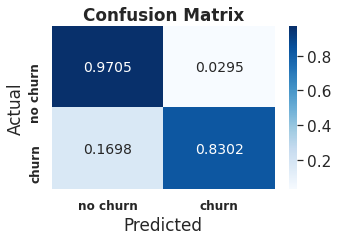

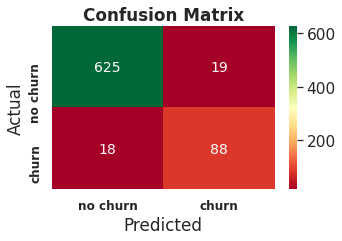


Classification report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       644
           1       0.82      0.83      0.83       106

    accuracy                           0.95       750
   macro avg       0.90      0.90      0.90       750
weighted avg       0.95      0.95      0.95       750



In [73]:
for param, param_name in zip(get_best_metric_epoch(history_nice), ['Loss', 'Accuracy', 'Precision', 'Recall']) :

    print('=====', param_name, '=====\n')
    model_path = f"modules/build_ml_models/saved_models/weight_{param+1:03d}.hdf5"    
    print (model_path)
    model_nice.load_weights(model_path)
    y_pred = model_nice.predict(x_test)
    threshold = 0.5
    y_pred = np.where(y_pred<=threshold, 0, 1)
    plot_confusion_matrix(y_test, y_pred, cmap='Blues', normalize='true')
    plot_confusion_matrix(y_test, y_pred, cmap='RdYlGn', normalize=None)
    print_classification_report(y_test, y_pred)